# Feature generation

## List of all possible features

Let us first have a look of what possible features we want to add to our ML model

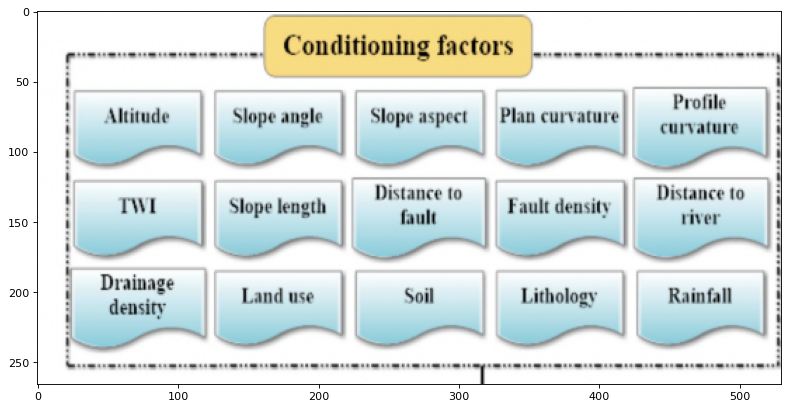

In [3]:
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

figure(figsize=(12, 8), dpi=80)
US_climate_img=mpimg.imread('https://i.ibb.co/Wx91PxV/features.png')
plt.imshow(US_climate_img)


# Load wells dataset

In [49]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_6486f6925a3b4963afc058e250e1f031 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_6486f6925a3b4963afc058e250e1f031 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_6486f6925a3b4963afc058e250e1f031 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='w5_9Bf-0UAn0b7wzNtBiXwm1sCXUnaPtmOIG--k0OcV0',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_6486f6925a3b4963afc058e250e1f031)

body = client_6486f6925a3b4963afc058e250e1f031.get_object(Bucket='aitofindbestwelllocation-donotdelete-pr-w1t2kzuzbwx2l0',Key='small_zone_dataset_wells.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

wells = pd.read_csv(body)
wells = wells[['longitude', 'latitude']]
wells.head()


,longitude,latitude
0,-119.342550,38.757700
1,-119.000000,39.000000
2,-120.000000,39.000000
3,-119.705551,39.043056
4,-119.161930,38.923980


The zone into consideration is:
<li> longitude: -120 to -119
<li> latitude: 38.7 to 39.4
<li> we stay within the frontiers of Nevada, so the surface is less than the surface of the square

Here is the Google map snapshot of the zone:

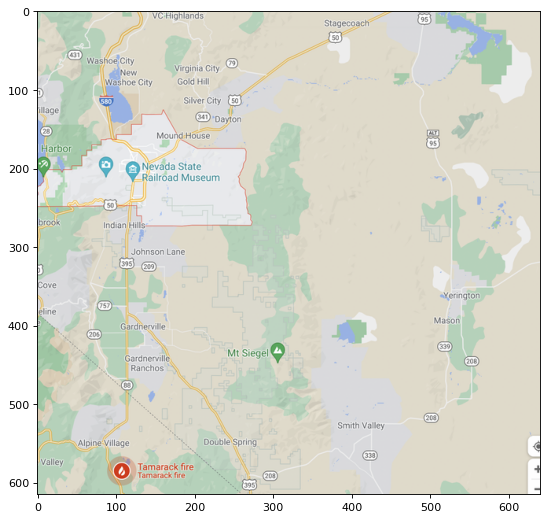

In [50]:
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

figure(figsize=(12, 8), dpi=80)
US_climate_img=mpimg.imread('https://i.ibb.co/VB5m9HP/Google-map-zone.png')
plt.imshow(US_climate_img)



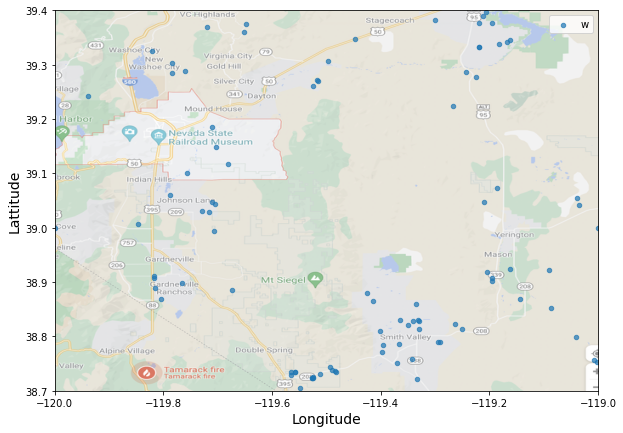

In [51]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
google_map_img=mpimg.imread('https://i.ibb.co/VB5m9HP/Google-map-zone.png')
ax = wells.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       colorbar=False, alpha=0.7,
                      )
plt.imshow(google_map_img, extent=[-120,-119 , 38.7, 39.4],alpha=0.7,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Lattitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend("wells",fontsize=10)
plt.show()

# Add Negative samples

The wells are the location of the positive samples. But later when we will want to train the model, we will need negative samples to in order to create a binary classifier. The features data that we will create in this notebook will need to be created for the negetive samples too, so now is a good time to create those negative samples fist.

Here are different possible strategies to create the negative samples:
1. For each good well, take all the closest wells to it, calculate the center of mass: this is a bad location
2. Use expertise to select bad locations for wells
3. Random selection on the map
4.use more criteria on the wells to basically rank them by quality(using features other than yield in the original dataset)

It would be interesting in the future to compare those different techniques. But first, let's do it simple and just use random generation.

In [52]:
#add the target column to the dataset
wells['target'] = 1

In [53]:
wells.head()

,longitude,latitude,target
0,-119.342550,38.757700,1
1,-119.000000,39.000000,1
2,-120.000000,39.000000,1
3,-119.705551,39.043056,1
4,-119.161930,38.923980,1


In [54]:
wells.describe()

,longitude,latitude,target
count,93.000000,93.000000,93.0
mean,-119.441451,38.996950,1.0
std,0.248379,0.232467,0.0
min,-120.000000,38.705187,1.0
25%,-119.674527,38.790345,1.0
50%,-119.414860,38.911009,1.0
75%,-119.219463,39.260600,1.0
max,-119.000000,39.396644,1.0


In [55]:
#generate 93 negative samples (TODO: check if we should generaate more than 93? less than 93?)
import random
random.seed(2021)
nb_samples = 0
while nb_samples < 93:
  x = -120 + random.random()
  y = 38.7 + 0.7 * random.random()

  #check if out of Nevada?
  x0, y0 = -120, 39
  x1, y1 = -119.6, 38.7
  if (y - y0) / (x -x0) < (y1 - y0) / (x1 - x0):
    continue

  nb_samples += 1
  #append at the end
  wells.loc[len(wells)]=[x,y,0]

  


In [56]:
#checks
assert len(wells)== 186

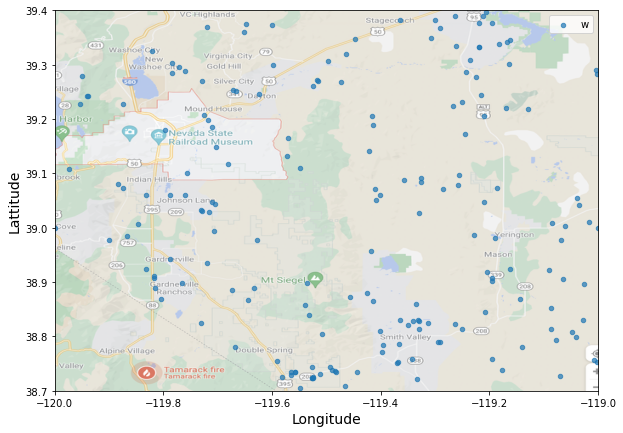

In [57]:
#look at the map with positive and negative samples
#TODO: put the negative samples in another color (red?)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
google_map_img=mpimg.imread('https://i.ibb.co/VB5m9HP/Google-map-zone.png')
ax = wells.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       colorbar=False, alpha=0.7,
                      )
plt.imshow(google_map_img, extent=[-120,-119 , 38.7, 39.4],alpha=0.7,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Lattitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend("wells",fontsize=10)
plt.show()

# Add Geological feature

It seems that "Geology is the single most important factor determining
groundwater occurrence." [source from litterature](https://www.researchgate.net/publication/335223999_Review_Advances_in_groundwater_potential_mapping?enrichId=rgreq-f1e4d8c725f3688f4aada4a96cfd35b3-XXX&enrichSource=Y292ZXJQYWdlOzMzNTIyMzk5OTtBUzo4OTY0Mzc3MDk3MDExMjJAMTU5MDczODgxMzUyMA%3D%3D&el=1_x_2&_esc=publicationCoverPdf)

Therefore, it is natural that we start by adding this as a mandatory feature.

we can get a fault map on this [link](https://gisweb.unr.edu/QuaternaryFaults/)



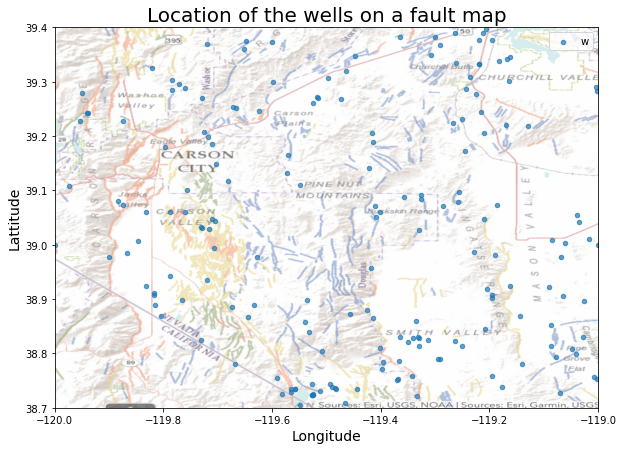

In [68]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img_mountains=mpimg.imread('https://i.ibb.co/WBgLMkk/fault-distance.png')
#remove the 4th channel
img_mountains = img_mountains[:,:,:3]
ax = wells.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       colorbar=False, alpha=0.7,
                      )
plt.imshow(img_mountains, extent=[-120,-119 , 38.7, 39.4],alpha=0.7,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Lattitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend("wells",fontsize=10)
plt.title("Location of the wells on a fault map", fontsize = 20)
plt.show()




Text(0.5, 1.0, 'Legend to understand the previous map of faults')

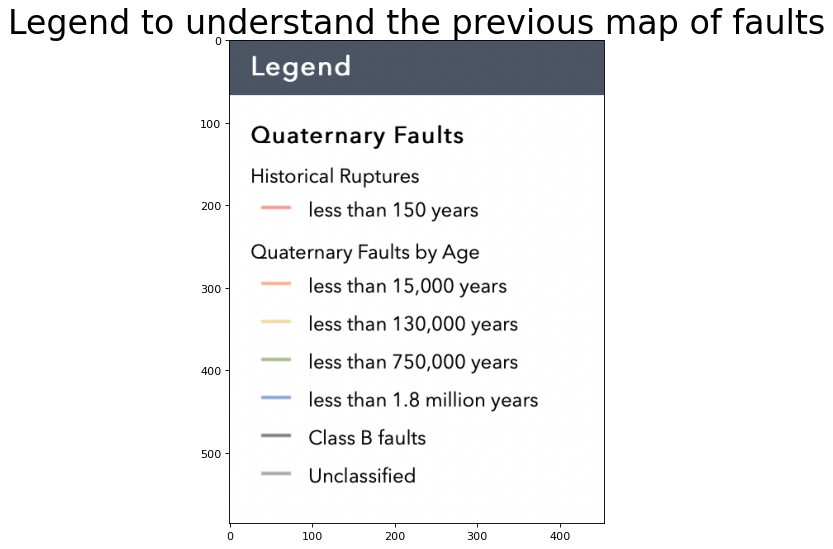

In [69]:
#legend:
figure(figsize=(12, 8), dpi=80)
legend_img=mpimg.imread('https://i.ibb.co/0DJCrP8/legend-fault.png')
plt.imshow(legend_img)
plt.title("Legend to understand the previous map of faults", fontsize = 30)




We now want to calculate the distance to each type of fault (there are 7 types).
Our first approach was to use Kmeans to find the main colors on the legend [source](https://towardsdatascience.com/finding-most-common-colors-in-python-47ea0767a06a). But actually a simple [online color picker](https://imagecolorpicker.com) can be used to detect the 7 colors really fast!

Another thing to note is that the fault map can be adjusted on the website to get a grey background, which doesnt look as good as the map with mountains and stuffs, but which is easier to work with to detect the colors with numpy

Let us define a function that can compare 2 images side by side, that will come handy:

In [70]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

def show_img_compar(img_1, img_2 , title = None):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    if title:
      plt.title(title, fontsize = 20)
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off') #hide the axis
    ax[1].axis('off')
    f.tight_layout()
    
    plt.show()

Let us load the 2 images, faults with mountains and fault with simple grey background:

(note: we convert them to RGB because they have 4 channels)

<class 'numpy.ndarray'>
(619, 640, 3)


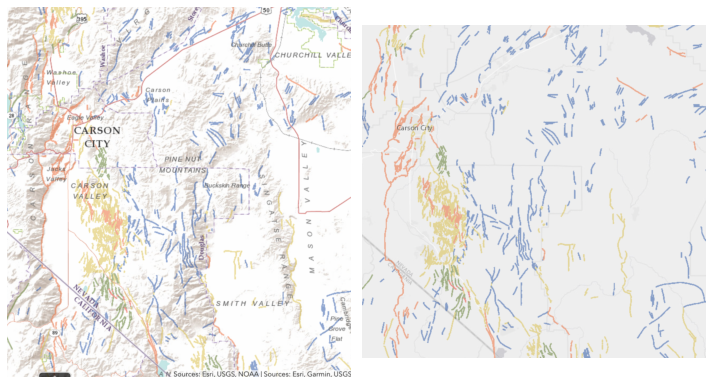

In [71]:
#using numpy
from PIL import Image
from numpy import asarray
  
  
# load the image and convert into
# numpy array
img=mpimg.imread('https://i.ibb.co/2SXctHW/fault-grey-background.png')
img = img[:,:,:3]
  
# asarray() class is used to convert
# PIL images into NumPy arrays
img = asarray(img)
img_mountains = asarray(img_mountains)
  
# <class 'numpy.ndarray'>
print(type(img))
  
#  shape
print(img.shape)

show_img_compar(img_mountains, img)


As you can see it is much easier to work with the grey background. Now let us use the online color picker to know the RGB values of the 7 colors of the faults on the map. Here are the results:


In [92]:
#using https://imagecolorpicker.com
colors = np.zeros((7,3))
colors[0] = [255,147,142]
colors[1] = [255,177,151]
colors[2] = [242,220,161]
colors[3] = [166,187,138]
colors[4] = [136,166,211]
colors[5] = [128,128,128]
colors[6] = [167,167,167]

colors = 1/255 * colors

colors

array([[1.        , 0.57647059, 0.55686275],
       [1.        , 0.69411765, 0.59215686],
       [0.94901961, 0.8627451 , 0.63137255],
       [0.65098039, 0.73333333, 0.54117647],
       [0.53333333, 0.65098039, 0.82745098],
       [0.50196078, 0.50196078, 0.50196078],
       [0.65490196, 0.65490196, 0.65490196]])

We can modify the original map to only keep the colors from the legend and see how it looks (we make the lines 10 pixels wide for visualization purposes)

In [99]:
modified_img = img.copy()
print("Processing please wait for a few seconds...")
for i in range(img.shape[0]):
  if i % 100 == 0:
    print(f"{i}/{img.shape[0]}")
  for j in range(img.shape[1]):
    # r,g,b = img[i,j]
    for color in colors:
      if np.linalg.norm(color - img[i,j]) < 20/(255):
        for di in range(-5, 5):
          for dj in range(-5, 5):
            ni = i + di
            nj = j + dj
            if ni >= 0 and ni < img.shape[0] and nj >= 0 and nj <img.shape[1]: 
              modified_img[ni,nj] = color
        break
    else:
      modified_img[i,j] = [1,1,1]
print("Process complete.")

Processing please wait for a few seconds...
0/619
100/619
200/619
300/619
400/619
500/619
600/619
Process complete.


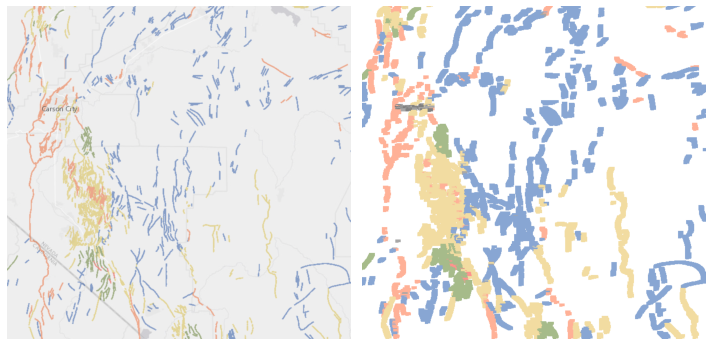

In [100]:
show_img_compar(img, modified_img)

It works well. Now that we saw it works well, we dont need to make the line as thick as 10 pixels wide for the actual calculation of distances, 1 pixel is just what we actually need.

In [101]:
modified_img = img.copy()
print("Processing please wait for a few seconds...")
for i in range(img.shape[0]):
  if i % 100 == 0:
    print(f"{i}/{img.shape[0]}")
  for j in range(img.shape[1]):
    # r,g,b = img[i,j]
    for color in colors:
      if np.linalg.norm(color - img[i,j]) < 20/(255):
        modified_img[i,j] = color
        break
    else:
      modified_img[i,j] = [1,1,1]
print("Process complete.")

Processing please wait for a few seconds...
0/619
100/619
200/619
300/619
400/619
500/619
600/619
Process complete.


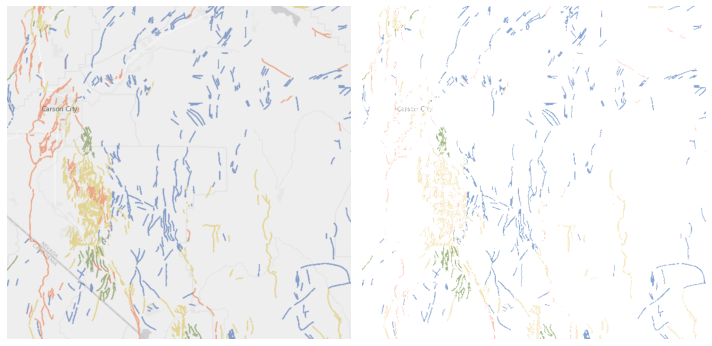

In [102]:
show_img_compar(img, modified_img)

With our bare eyes, we cannot see all the lines, but we know they are there from the previous map (the one with 5 pixels wide lines)

## We can now calculate our feature: the distance to each kind of colored fault

In [103]:
#initialize the new features with "infinite" values
for i in range(7):
  col = "fault" + str(i)
  wells[col] = 10000

In [104]:
#define a function to calculate distance between two points from whom we have GPS coordinates
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

def distance_km(lat1, lon1, lat2, lon2):

  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance

In [113]:
print("Please be patient, it will take some time")
blue_colors = colors[:,2]
for line in range(len(wells)):
  print(f"{line}/{len(wells)}")
  longitude0 = wells.loc[line, "longitude"]
  latitude0 = wells.loc[line, "latitude"]
  distances = [10000]*7
  for i in range(modified_img.shape[0]):
    # if i % 100 == 0:
    #   print(i)
    for j in range(modified_img.shape[1]):
      color_pix = modified_img[i,j]
      # a small trick is to notice that all the 8 colors ( 7 feature colors and white) are uniquely determined by their blue channel value:
      blue_intensity = color_pix[2]
      is_white = ((1 - blue_intensity) < 0.01)
      if is_white:
        continue
      #now detect the feature color
      for idx, blue_color in enumerate(blue_colors):

        if abs(blue_intensity - blue_color) < 0.01:
          longitude1 = -120 + j /modified_img.shape[0]
          latitude1 = 38.7 + (39.4 - 38.7) / modified_img.shape[1] * i
          current_distance = distance_km(latitude0, longitude0, latitude1, longitude1)
          # print(current_distance)

          distances[idx] = min(distances[idx],current_distance)
          
          break
  for idx in range(7):
    col = "fault" + str(idx)
    wells.loc[line, col] = distances[idx]
print("Process complete")

Please be patient, it will take some time
0/186
1/186
2/186
3/186
4/186
5/186
6/186
7/186
8/186
9/186
10/186
11/186
12/186
13/186
14/186
15/186
16/186
17/186
18/186
19/186
20/186
21/186
22/186
23/186
24/186
25/186
26/186
27/186
28/186
29/186
30/186
31/186
32/186
33/186
34/186
35/186
36/186
37/186
38/186
39/186
40/186
41/186
42/186
43/186
44/186
45/186
46/186
47/186
48/186
49/186
50/186
51/186
52/186
53/186
54/186
55/186
56/186
57/186
58/186
59/186
60/186
61/186
62/186
63/186
64/186
65/186
66/186
67/186
68/186
69/186
70/186
71/186
72/186
73/186
74/186
75/186
76/186
77/186
78/186
79/186
80/186
81/186
82/186
83/186
84/186
85/186
86/186
87/186
88/186
89/186
90/186
91/186
92/186
93/186
94/186
95/186
96/186
97/186
98/186
99/186
100/186
101/186
102/186
103/186
104/186
105/186
106/186
107/186
108/186
109/186
110/186
111/186
112/186
113/186
114/186
115/186
116/186
117/186
118/186
119/186
120/186
121/186
122/186
123/186
124/186
125/186
126/186
127/186
128/186
129/186
130/186
131/186
132/186
133/

Let us check what we get in the wells dataframe:

In [120]:
wells.head()

,longitude,latitude,target,fault0,fault1,fault2,fault3,fault4,fault5,fault6
0,-119.342550,38.757700,1.0,61.379975,10.018325,18.666062,41.437305,0.030375,42.837627,10.269944
1,-119.000000,39.000000,1.0,64.617668,5.273444,21.107012,53.641358,1.251336,69.404474,30.520319
2,-120.000000,39.000000,1.0,33.263556,5.835872,14.555254,16.701855,5.997610,13.529671,13.539749
3,-119.705551,39.043056,1.0,19.831489,3.260279,0.193372,4.876578,1.523177,16.262283,1.221805
4,-119.161930,38.923980,1.0,57.179331,3.319162,14.216486,50.574469,3.475881,54.781805,30.849068


We successfully added 7 features to our dataset!

Let us save it

In [121]:
#save
wells.to_csv("dataset_with_features.csv")